In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer,OneHotEncoder,LabelEncoder
import seaborn as sns
from time import strftime,gmtime
import re

In [2]:
df_train = pd.read_csv('Dataset/train.csv')
df_gs = pd.read_csv('Dataset/gender_submission.csv')
df_test = pd.read_csv('Dataset/test.csv')
df_train_tmp = pd.read_csv('Dataset/train_temp.csv')
df_test_tmp = pd.read_csv('Dataset/test_tmp.csv')

In [3]:
df_train_tmp.drop('Ticket',axis=1,inplace=True)
df_test_tmp.drop('Ticket',axis=1,inplace=True)

In [4]:
print('Test shape {}'.format(df_test.shape))
print('Train shape {}'.format(df_train.shape))

Test shape (418, 11)
Train shape (891, 12)


In [5]:
y = df_train['Survived']
df_train = df_train.merge(df_train_tmp,on='PassengerId',how='left')
df_test = df_test.merge(df_test_tmp,on='PassengerId',how='left')
del df_train_tmp
del df_test_tmp
df_train.drop(['Survived','PassengerId','Ticket'],axis=1,inplace=True)
df_test.drop(['PassengerId','Ticket'],axis=1,inplace=True)
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 26 columns):
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
A5          22 non-null float64
A4          7 non-null float64
Other       2 non-null float64
C           5 non-null float64
CA          42 non-null float64
FC          6 non-null float64
LINE        4 non-null float64
PP          14 non-null float64
PC          60 non-null float64
SC          18 non-null float64
SO          11 non-null float64
Paris       9 non-null float64
AH          3 non-null float64
O2          15 non-null float64
OQ          20 non-null float64
WC          10 non-null float64
WE          3 non-null float64
dtypes: float64(19), int64(3), object(4)
memory usage: 187.9+ KB
None
<c

In [6]:
def null_graph(X_train,X_test,show_graph=False):
#     print(X_train.isna().sum())
#     print(X_test.isna().sum())
    if show_graph:
        plt.bar(range(len(X_train.columns)),X_train.isna().sum().values)
        plt.bar(range(len(X_test.columns)),X_test.isna().sum().values)
        plt.ylabel('Count')
        plt.xlabel('Columns')
        plt.title('Count of null vs columns')
        plt.xticks
        plt.legend(('Train', 'Test'))
        plt.show()

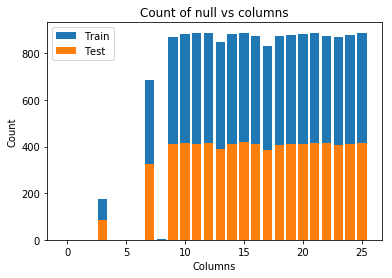

In [7]:
null_graph(df_train,df_test,show_graph=True)

In [8]:
df_train['Embarked'].fillna('S',inplace=True)
df_test['Embarked'].fillna('S',inplace=True)

In [9]:
def age_feature_engg(X):
    age_avg = X['Age'].mean()
    age_std = X['Age'].std()
    age_null_count = X['Age'].isna().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    X.loc[np.isnan(X['Age']), 'Age'] = age_null_random_list
    X['Age'] = X['Age'].astype(int)
    X.loc[ X['Age'] <= 16, 'Age'] 					 = 0
    X.loc[(X['Age'] > 16) & (X['Age'] <= 32), 'Age'] = 1
    X.loc[(X['Age'] > 32) & (X['Age'] <= 48), 'Age'] = 2
    X.loc[(X['Age'] > 48) & (X['Age'] <= 64), 'Age'] = 3
    X.loc[ X['Age'] > 64, 'Age'] ;

In [10]:
age_feature_engg(df_train)
age_feature_engg(df_test)

In [11]:
def fare_feature_engg(X):
    X['Fare'].fillna(X['Fare'].median(),inplace=True)
    X.loc[ X['Fare'] <= 7.91, 'Fare'] 						        = 0
    X.loc[(X['Fare'] > 7.91) & (X['Fare'] <= 14.454), 'Fare'] = 1
    X.loc[(X['Fare'] > 14.454) & (X['Fare'] <= 31), 'Fare']   = 2
    X.loc[ X['Fare'] > 31, 'Fare'] 							        = 3
    X['Fare'] = X['Fare'].astype(int)
    X['Fare'].fillna(df_train['Fare'].median(),inplace=True)

In [12]:
fare_feature_engg(df_train)
fare_feature_engg(df_test)

In [13]:
def name_title_feature_engg(X):
    def get_title(name):
        title_search = re.search(' ([A-Za-z]+)\.', name)
        if title_search:
            return title_search.group(1)
        return ""
    X
    X['Title'] = X['Name'].apply(get_title)
    X['Title'] = X['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    X['Title'] = X['Title'].replace('Mlle', 'Miss')
    X['Title'] = X['Title'].replace('Ms', 'Miss')
    X['Title'] = X['Title'].replace('Mme', 'Mrs')
    X['Title'] = LabelEncoder().fit_transform(X['Title'])
    X['Name_length'] = X['Name'].apply(len)
    X.drop('Name',axis=1,inplace=True)

In [14]:
name_title_feature_engg(df_train)
name_title_feature_engg(df_test)

In [15]:
def family_feature_engg(X):
    X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
    X.drop('SibSp',axis=1,inplace=True)

In [16]:
family_feature_engg(df_train)
family_feature_engg(df_test)

In [17]:
def cabin_feature_engg(X):  
    arr_temp = np.zeros(len(X))
    arr_temp[X.Cabin[(X.Cabin.isna())].index] = 1
    df_temp = pd.DataFrame(arr_temp,columns=['Cabin_null'])
    X = pd.concat([X,df_temp],axis=1,ignore_index=False)
    X.Cabin.fillna(-1,inplace=True)
    X.Cabin.fillna(-1,inplace=True)
    arr = {'A':[],'B':[],'C':[],'D':[],'E':[],'F':[],'G':[],'H':[]}
    for row in range(0,len(X)):
        if X.loc[row,'Cabin'] != -1:
            if X.loc[row,'Cabin'].startswith('A'):
                arr['A'].append(row)
            elif X.loc[row,'Cabin'].startswith('B'):
                arr['B'].append(row)
            elif X.loc[row,'Cabin'].startswith('C'):
                arr['C'].append(row)
            elif X.loc[row,'Cabin'].startswith('D'):
                arr['D'].append(row)
            elif X.loc[row,'Cabin'].startswith('E'):
                arr['E'].append(row)
            elif X.loc[row,'Cabin'].startswith('F'):
                arr['F'].append(row)
            elif X.loc[row,'Cabin'].startswith('G'):
                arr['G'].append(row)
            elif X.loc[row,'Cabin'].startswith('T'):
                arr['H'].append(row)
    for key in arr.keys():
        X['Cabin_{}'.format(key)] = 0
#         for row in arr[key]:
        X.loc[arr[key],'Cabin_{}'.format(key)] = 1
    X.drop('Cabin',inplace=True,axis=1)
    return X

In [18]:
df_train = cabin_feature_engg(df_train)
df_test = cabin_feature_engg(df_test)

In [19]:
df_train.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,A5,A4,Other,C,...,FamilySize,Cabin_null,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_H
0,3,male,1,0,0,S,1.0,NaN,NaN,NaN,...,2,1.0,0,0,0,0,0,0,0,0
1,1,female,2,0,3,C,NaN,NaN,NaN,NaN,...,2,0.0,0,0,1,0,0,0,0,0
2,3,female,1,0,1,S,NaN,NaN,NaN,NaN,...,1,1.0,0,0,0,0,0,0,0,0
3,1,female,2,0,3,S,NaN,NaN,NaN,NaN,...,2,0.0,0,0,1,0,0,0,0,0
4,3,male,2,0,1,S,NaN,NaN,NaN,NaN,...,1,1.0,0,0,0,0,0,0,0,0


In [20]:
df_test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,A5,A4,Other,C,...,FamilySize,Cabin_null,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_H
0,3,male,2,0,0,Q,NaN,NaN,NaN,NaN,...,1,1.0,0,0,0,0,0,0,0,0
1,3,female,2,0,0,S,NaN,NaN,NaN,NaN,...,2,1.0,0,0,0,0,0,0,0,0
2,2,male,3,0,1,Q,NaN,NaN,NaN,NaN,...,1,1.0,0,0,0,0,0,0,0,0
3,3,male,1,0,1,S,NaN,NaN,NaN,NaN,...,1,1.0,0,0,0,0,0,0,0,0
4,3,female,1,1,1,S,NaN,NaN,NaN,NaN,...,3,1.0,0,0,0,0,0,0,0,0


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 35 columns):
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null int32
Parch          891 non-null int64
Fare           891 non-null int32
Embarked       891 non-null object
A5             22 non-null float64
A4             7 non-null float64
Other          2 non-null float64
C              5 non-null float64
CA             42 non-null float64
FC             6 non-null float64
LINE           4 non-null float64
PP             14 non-null float64
PC             60 non-null float64
SC             18 non-null float64
SO             11 non-null float64
Paris          9 non-null float64
AH             3 non-null float64
O2             15 non-null float64
OQ             20 non-null float64
WC             10 non-null float64
WE             3 non-null float64
Title          891 non-null int64
Name_length    891 non-null int64
FamilySize     891 non-null int64


In [22]:
def one_hot_encoder(X,usecol,columns):
    le = LabelEncoder()
    integer_encoded = le.fit_transform(X[usecol])
    ohe = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(X), 1)
    integer_encoded = ohe.fit_transform(integer_encoded)
    df_ohe_tmp = pd.DataFrame(integer_encoded,columns=columns)
    X = pd.concat([X,df_ohe_tmp],axis=1)
    X.drop(usecol,axis=1,inplace=True)
    return X

In [23]:
cols_Embarked = ['Embarked_C','Embarked_Q','Embarked_S']
cols_Sex = ['Male','Female']
cols_Pclass = ['Pclass_1','Pclass_2','Pclass_3']
df_train = one_hot_encoder(df_train,'Embarked',cols_Embarked)
df_train = one_hot_encoder(df_train,'Sex',cols_Sex)
df_train = one_hot_encoder(df_train,'Pclass',cols_Pclass)
df_test = one_hot_encoder(df_test,'Embarked',cols_Embarked)
df_test = one_hot_encoder(df_test,'Sex',cols_Sex)
df_test = one_hot_encoder(df_test,'Pclass',cols_Pclass)

In [24]:
df_train.fillna(0,axis=1,inplace=True)
df_test.fillna(0,axis=1,inplace=True)

In [25]:
df_train

,Age,Parch,Fare,A5,A4,Other,C,CA,FC,LINE,...,Cabin_G,Cabin_H,Embarked_C,Embarked_Q,Embarked_S,Male,Female,Pclass_1,Pclass_2,Pclass_3
0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,2,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,2,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6,3,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
7,0,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
8,1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
9,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


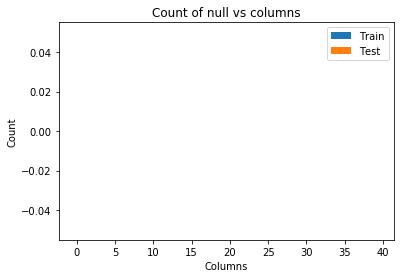

In [26]:
null_graph(df_train,df_test,show_graph=True)

In [27]:
df_test.to_csv('Dataset/feature_engg_test.csv',index=False)
pd.concat([df_train,y],axis=1).to_csv('Dataset/feature_engg_train.csv',index=False)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin

In [29]:
df_train.head()

,Age,Parch,Fare,A5,A4,Other,C,CA,FC,LINE,...,Cabin_G,Cabin_H,Embarked_C,Embarked_Q,Embarked_S,Male,Female,Pclass_1,Pclass_2,Pclass_3
0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,2,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,2,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [30]:
df_train.describe()

,Age,Parch,Fare,A5,A4,Other,C,CA,FC,LINE,...,Cabin_G,Cabin_H,Embarked_C,Embarked_Q,Embarked_S,Male,Female,Pclass_1,Pclass_2,Pclass_3
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.161616,0.381594,1.505051,0.024691,0.007856,0.002245,0.005612,0.047138,0.006734,0.004489,...,0.004489,0.001122,0.188552,0.086420,0.725028,0.352413,0.647587,0.242424,0.206510,0.551066
std,7.614941,0.806057,1.118148,0.155270,0.088337,0.047351,0.074743,0.212053,0.081830,0.066890,...,0.066890,0.033501,0.391372,0.281141,0.446751,0.477990,0.477990,0.428790,0.405028,0.497665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,80.000000,6.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
for col in df_train.columns:
    print("{} has {} unique values".format(col,df_train[col].nunique()))

Age has 10 unique values
Parch has 7 unique values
Fare has 4 unique values
A5 has 2 unique values
A4 has 2 unique values
Other has 2 unique values
C has 2 unique values
CA has 2 unique values
FC has 2 unique values
LINE has 2 unique values
PP has 2 unique values
PC has 2 unique values
SC has 2 unique values
SO has 2 unique values
Paris has 2 unique values
AH has 2 unique values
O2 has 2 unique values
OQ has 2 unique values
WC has 2 unique values
WE has 2 unique values
Title has 5 unique values
Name_length has 50 unique values
FamilySize has 9 unique values
Cabin_null has 2 unique values
Cabin_A has 2 unique values
Cabin_B has 2 unique values
Cabin_C has 2 unique values
Cabin_D has 2 unique values
Cabin_E has 2 unique values
Cabin_F has 2 unique values
Cabin_G has 2 unique values
Cabin_H has 2 unique values
Embarked_C has 2 unique values
Embarked_Q has 2 unique values
Embarked_S has 2 unique values
Male has 2 unique values
Female has 2 unique values
Pclass_1 has 2 unique values
Pclass_

In [32]:
class CategoryTransformer(TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        for col in X.columns:
            if X[col].dtype.name == 'object':
                X[col] = X[col].astype('category')
                X[col] = X[col].cat.codes
        return X

In [33]:
class NullTransformer(TransformerMixin):
    def transform(self,X):
        imputer = Imputer(axis=1)
        X = pd.DataFrame(imputer.fit_transform(X),columns=X.columns)
        return X

In [34]:
df_train = df_train[['Age', 'Parch', 'Fare', 'Title', 'Name_length', 'FamilySize',
       'Cabin_null', 'Cabin_B', 'Embarked_C', 'Embarked_S', 'Male', 'Female',
       'Pclass_1', 'Pclass_2', 'Pclass_3']]
df_test = df_test[['Age', 'Parch', 'Fare', 'Title', 'Name_length', 'FamilySize',
       'Cabin_null', 'Cabin_B', 'Embarked_C', 'Embarked_S', 'Male', 'Female',
       'Pclass_1', 'Pclass_2', 'Pclass_3']]

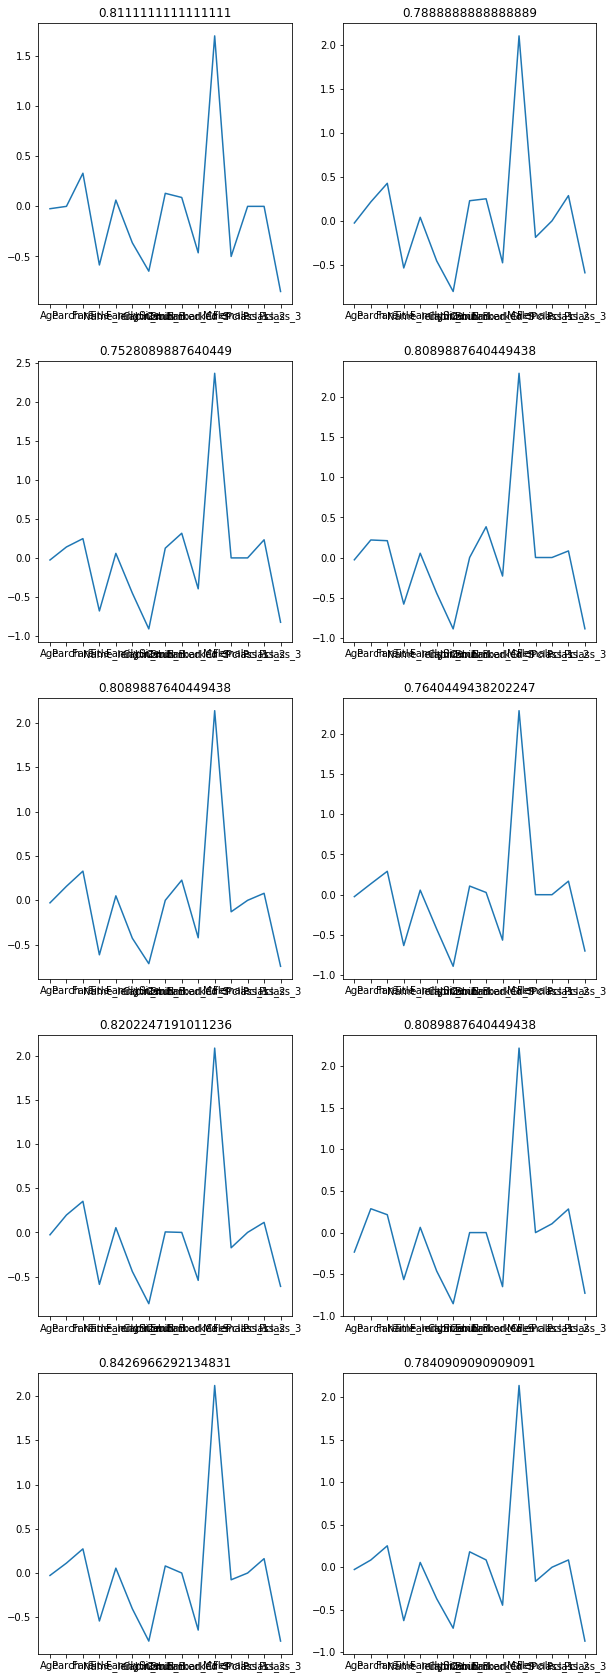

In [35]:
kfold = StratifiedKFold(n_splits=10,random_state=42)
fig, ax = plt.subplots(5,2,figsize=(10,30))
for i,(train_idx,valid_idx) in enumerate(kfold.split(df_train,y)):
    X_train,y_train = df_train.iloc[train_idx],y[train_idx]
    X_valid,y_valid = df_train.iloc[valid_idx],y[valid_idx]
    lr = LogisticRegression(penalty='l1',random_state=42)
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_valid)
#     print(accuracy_score(y_pred=y_pred,y_true=y_valid))
    row = i//2
    col = i%2
    ax[row,col].plot(df_train.columns,lr.coef_.reshape(len(df_train.columns),1))
    ax[row,col]
    ax[row,col].set_title(accuracy_score(y_pred=y_pred,y_true=y_valid))
plt.show()

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 15 columns):
Age            891 non-null int32
Parch          891 non-null int64
Fare           891 non-null int32
Title          891 non-null int64
Name_length    891 non-null int64
FamilySize     891 non-null int64
Cabin_null     891 non-null float64
Cabin_B        891 non-null int64
Embarked_C     891 non-null float64
Embarked_S     891 non-null float64
Male           891 non-null float64
Female         891 non-null float64
Pclass_1       891 non-null float64
Pclass_2       891 non-null float64
Pclass_3       891 non-null float64
dtypes: float64(8), int32(2), int64(5)
memory usage: 144.4 KB


0.8
0.7777777777777778
0.7865168539325843
0.8539325842696629
0.8314606741573034
0.797752808988764
0.8426966292134831
0.7640449438202247
0.8651685393258427
0.8409090909090909


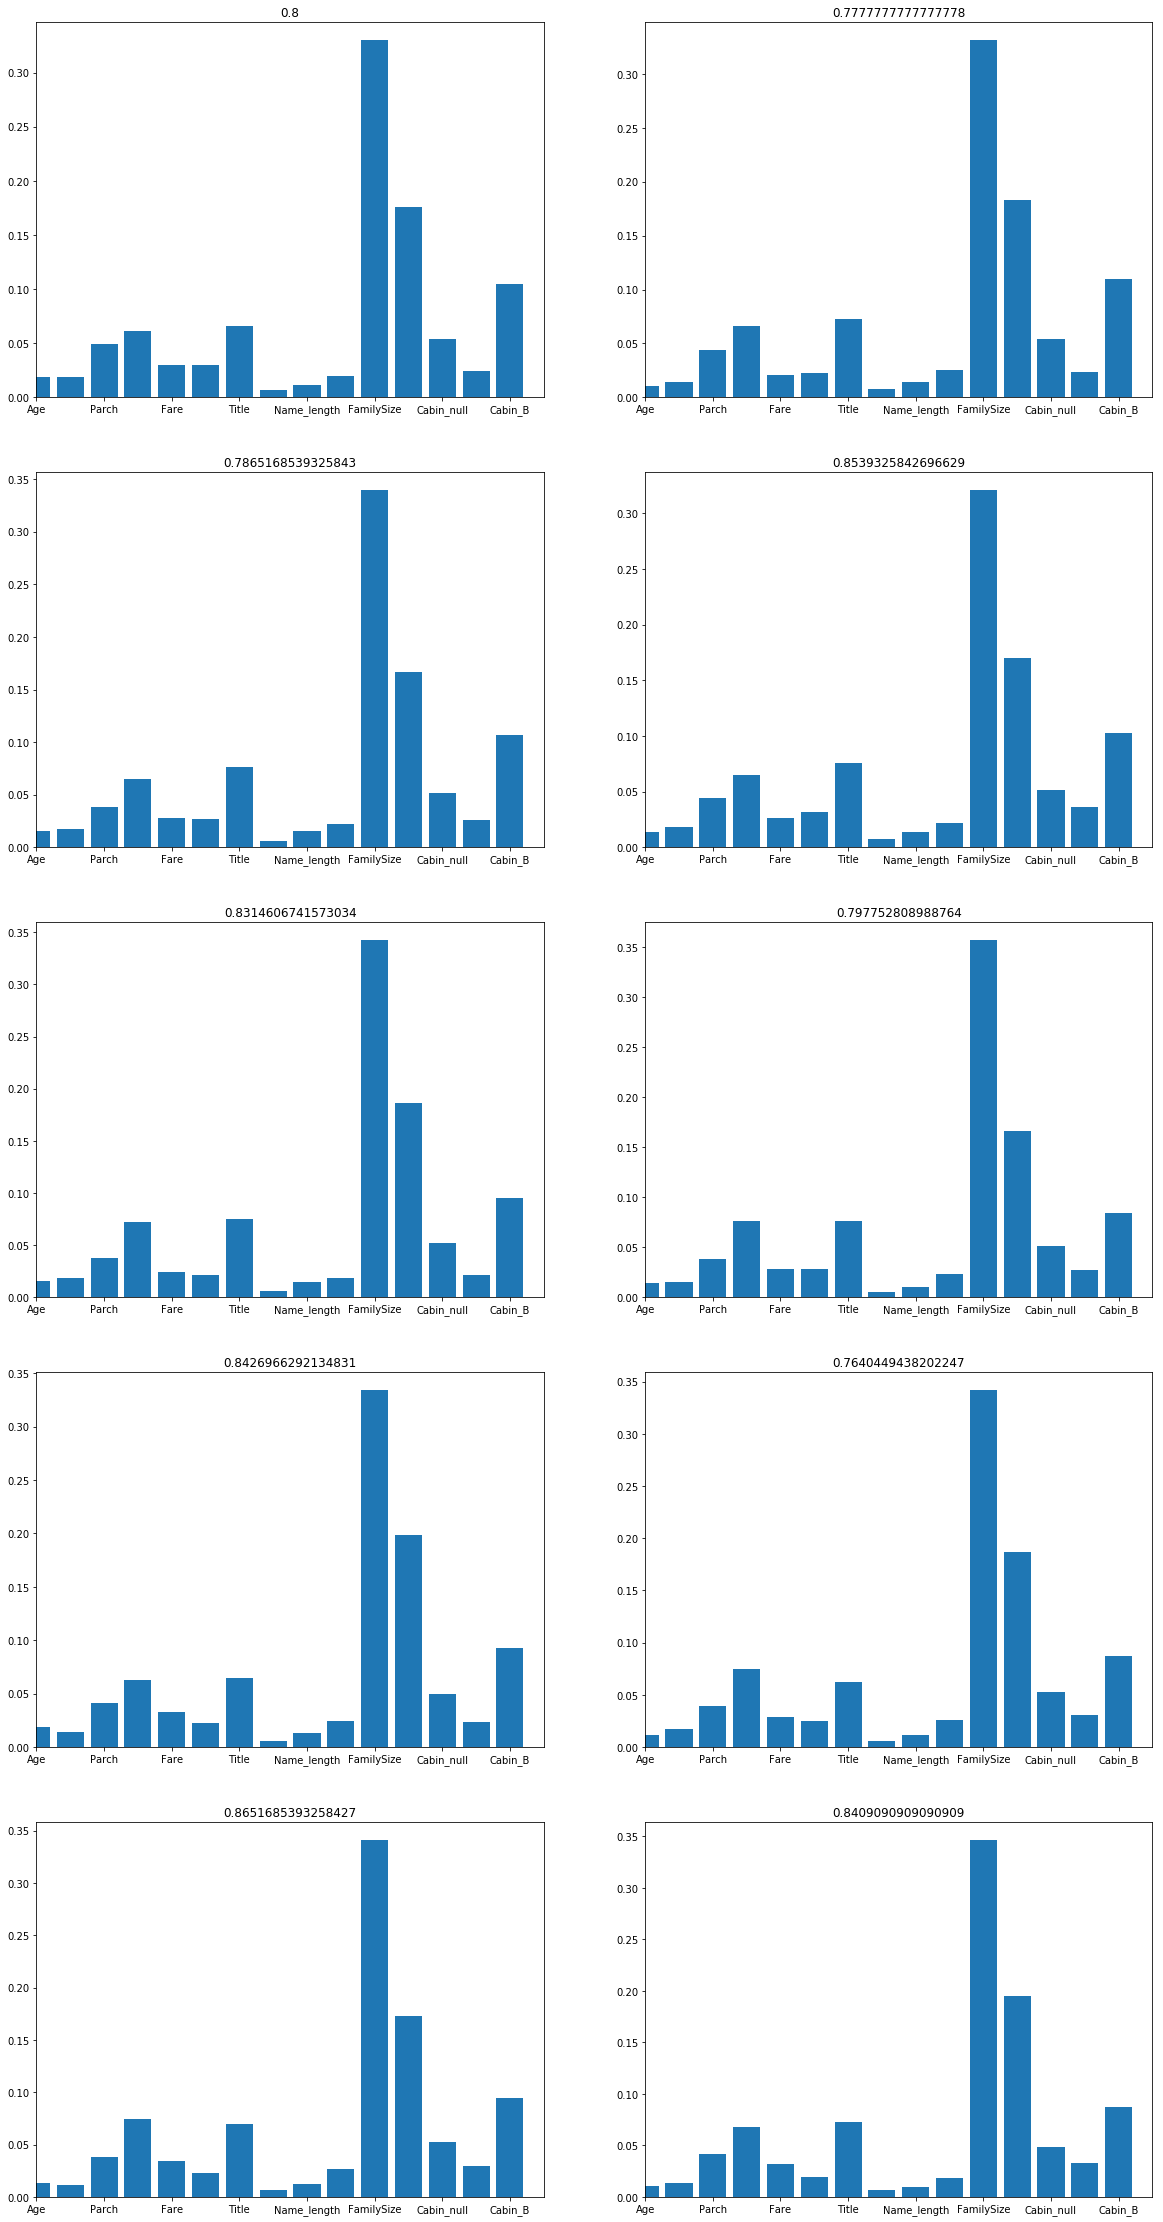

In [37]:
kfold = StratifiedKFold(n_splits=10,random_state=42)
fig, ax = plt.subplots(5,2,figsize=(20,40))
max_accr = 0
for i,(train_idx,valid_idx) in enumerate(kfold.split(df_train,y)):
    X_train,y_train = df_train.iloc[train_idx],y[train_idx]
    X_valid,y_valid = df_train.iloc[valid_idx],y[valid_idx]
    rf = ExtraTreesClassifier(20,min_samples_split=10,random_state=23,max_leaf_nodes=30)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_valid)
    accr = accuracy_score(y_pred=y_pred,y_true=y_valid)
    print(accr)
    row = i//2
    col = i%2
    if(accr>0):
        max_accr = accr
        model = rf
    ax[row,col].bar(range(0,len(rf.feature_importances_)),rf.feature_importances_)
    ax[row,col].set_xticklabels(df_train.columns)
    ax[row,col].set_xlim(0, len(rf.feature_importances_))
    ax[row,col].set_title(accuracy_score(y_pred=y_pred,y_true=y_valid))
plt.show()

In [44]:
df_train.columns[(model.feature_importances_>0.015)]

Index(['Fare', 'Title', 'Name_length', 'FamilySize', 'Cabin_null',
       'Embarked_S', 'Male', 'Female', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [39]:
df_train.columns

Index(['Age', 'Parch', 'Fare', 'Title', 'Name_length', 'FamilySize',
       'Cabin_null', 'Cabin_B', 'Embarked_C', 'Embarked_S', 'Male', 'Female',
       'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [40]:
y_pred = model.predict(df_test)

In [41]:
df_gs['Survived'] = y_pred

In [42]:
df_gs['Survived'].value_counts()

0    290
1    128
Name: Survived, dtype: int64

In [43]:
curr_time = strftime("%Y-%m-%d-%H-%M-%S")
df_gs.to_csv('My_ouptuts/output{}.csv'.format(curr_time),index=False)